In [2]:
import os
import re
import pandas as pd
import numpy as np
import seaborn as sns

# Training time

In [21]:
data = pd.read_csv("out/b0313/time_table.csv")
data['ver'] = data['model'].apply(lambda x: "v8" if 'v8' in x else "v9")
data["minutes"] = data["time"] / 60
baseline = 1.2696348349253337
data["relative"] = data["minutes"] / baseline
data.head(5)

,model,n,time,params,location,ver,minutes,relative
0,yolov8m,16,259.018047,25.9,home,v8,4.316967,3.400165
1,yolov9e,128,974.646500,57.3,home,v9,16.244108,12.794315
2,yolov9c,16,409.868521,25.3,home,v9,6.831142,5.380399
3,yolov8x,128,1005.424817,68.2,home,v8,16.757080,13.198346
4,yolov9e,32,1105.462378,57.3,home,v9,18.424373,14.511553


In [20]:
data.query("model == 'yolov8n' and n == 16").minutes.min()

1.2696348349253337

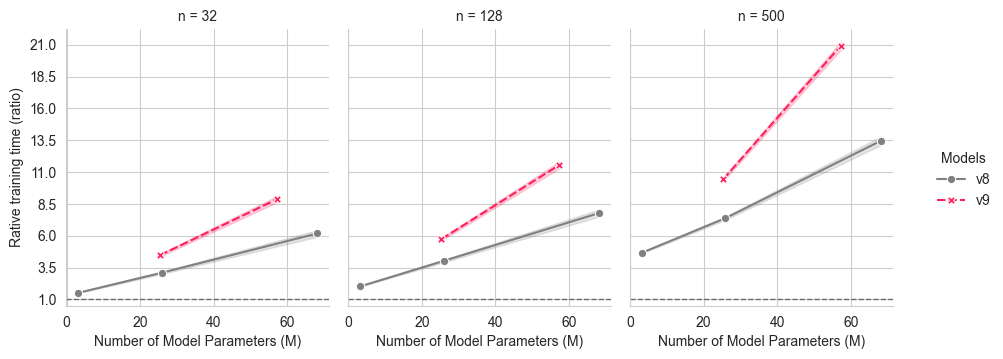

In [36]:
sns.set_style("whitegrid")
g = sns.FacetGrid(
    data.query("n in [32, 128, 500]"),
    col="n",
    col_order=[32, 128, 500],
    #row="location",
    margin_titles=True,
    sharey="all",)
g.map_dataframe(
    sns.lineplot,
    x="params",
    y="relative",
    hue="ver",
    style="ver",
    hue_order=["v8", "v9"],
    style_order=["v8", "v9"],
    err_style="band",
    errorbar=("se", 2),
    markers=True,
    palette=["Grey", "#FF1F5B"],
)
g.set(
    yticks=np.arange(1, 22.5, 2.5),
    ylabel="Rative training time (ratio)",
    xlabel="Number of Model Parameters (M)",
)
g.add_legend(title="Models")
# draw baseline at 1
for ax in g.axes[0]:
    ax.axhline(y=1, color='black', linewidth=1, linestyle='--', alpha=0.5)
g.figure.set_size_inches(10, 4)
g.figure.savefig(os.path.join("out", "b0313", "fig5_training.png"), dpi=300)

,model,n,time,params,location,ver,minutes,relative
0,yolov8m,16,259.018047,25.9,home,v8,4.316967,3.400165
1,yolov9e,128,974.646500,57.3,home,v9,16.244108,12.794315
2,yolov9c,16,409.868521,25.3,home,v9,6.831142,5.380399
3,yolov8x,128,1005.424817,68.2,home,v8,16.757080,13.198346
4,yolov9e,32,1105.462378,57.3,home,v9,18.424373,14.511553
...,...,...,...,...,...,...,...,...
12203,yolov8m,500,447.543804,25.9,projects,v8,7.459063,5.874968
12204,yolov9e,16,432.131641,57.3,projects,v9,7.202194,5.672650
12205,yolov8m,64,200.006936,25.9,projects,v8,3.333449,2.625518
12206,yolov8x,32,342.508847,68.2,projects,v8,5.708481,4.496160


# Inference time

In [41]:
FILE_OUT = os.path.join("out", "b0313", "fig5_inference.png")


def find_init(lines):
    s = []
    for line in lines:
        s += [re.search(r"Ultralytics YOLOv8", line)]
    return np.where(s)[0]


def find_model(s):
    find = re.findall(r"YOLOv\d.", s)[0]
    return str(find)


def find_device(s):
    return "CPU" if "CPU" in s else "GPU"


def find_ms(s):
    ms_str = re.findall(r"\d+\.\d+ms", s)[0]
    return float(ms_str[:-2])

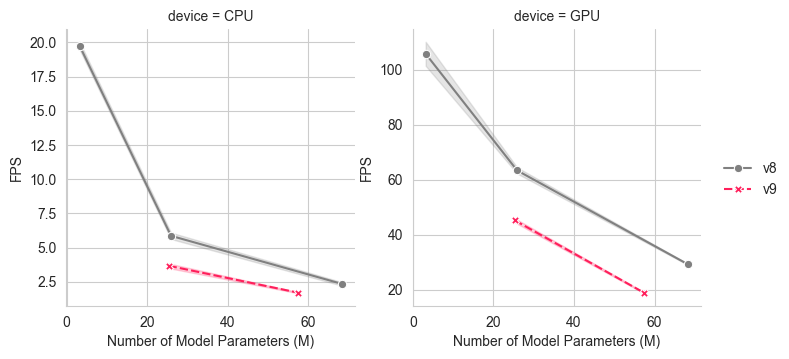

In [42]:
lines = open("data/mock/log.txt").readlines()

idx_init = find_init(lines)
idx_model = idx_init + 1
idx_iter_st = idx_init + 3
idx_iter_ed = idx_init + 3 + 64


data = pd.DataFrame(data=None)
for i in range(len(idx_init)):
    str_model = lines[idx_model[i]]
    str_device = lines[idx_init[i]]
    idx_st = idx_iter_st[i]
    idx_ed = idx_iter_ed[i]
    model = find_model(str_model)
    device = find_device(str_device)
    ms = []
    for j in range(idx_st, idx_ed):
        ms += [find_ms(lines[j])]
    data_tmp = pd.DataFrame(data=dict({"model": model, "device": device, "ms": ms}))
    data = pd.concat([data, data_tmp])

# turn model to string
data["fps"] = 1000 / data["ms"]
data["yolo"] = data["model"].apply(lambda x: "v8" if "8" in x else "v9")

df_param = pd.DataFrame(
    data={
        "model": ["YOLOv8n", "YOLOv9c", "YOLOv8m", "YOLOv9e", "YOLOv8x"],
        "size": [3.2, 25.3, 25.9, 57.3, 68.2],
    }
)
data = pd.merge(data, df_param, how="left")


sns.set_style("whitegrid")
g = sns.FacetGrid(
    data,
    col="device",
    col_order=["CPU", "GPU"],
    col_wrap=2,
    margin_titles=True,
    sharey=False,
)
g.map_dataframe(
    sns.lineplot,
    x="size",
    y="fps",
    hue="yolo",
    style="yolo",
    hue_order=["v8", "v9"],
    style_order=["v8", "v9"],
    err_style="band",
    errorbar=("se", 2),
    markers=True,
    palette=["Grey", "#FF1F5B"],
)
g.set(
    ylabel="FPS",
    xlabel="Number of Model Parameters (M)",
)

g.figure.subplots_adjust(right=1.2)
g.add_legend()
g.figure.set_size_inches(8, 4)
g.figure.savefig(FILE_OUT, dpi=300)

In [43]:
data

,model,device,ms,fps,yolo,size
0,YOLOv8n,CPU,62.9,15.898251,v8,3.2
1,YOLOv8n,CPU,56.1,17.825312,v8,3.2
2,YOLOv8n,CPU,55.2,18.115942,v8,3.2
3,YOLOv8n,CPU,51.3,19.493177,v8,3.2
4,YOLOv8n,CPU,49.1,20.366599,v8,3.2
...,...,...,...,...,...,...
635,YOLOv9e,GPU,52.9,18.903592,v9,57.3
636,YOLOv9e,GPU,53.7,18.621974,v9,57.3
637,YOLOv9e,GPU,53.1,18.832392,v9,57.3
638,YOLOv9e,GPU,53.8,18.587361,v9,57.3


In [44]:
data.loc[:, ["model", "device", "fps"]].groupby(["model", "device"]).aggregate(["mean", "std"])

fps           
                      mean        std
model   device                       
YOLOv8m CPU       5.862784   0.940588
        GPU      63.286615   4.467837
YOLOv8n CPU      19.768982   1.115293
        GPU     105.718299  17.478519
YOLOv8x CPU       2.357122   0.516056
        GPU      29.211807   0.911822
YOLOv9c CPU       3.674196   0.684758
        GPU      45.159232   3.020016
YOLOv9e CPU       1.715719   0.174222
        GPU      18.890441   0.834113